In [2]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric import datasets

import numpy as np
import random

import matplotlib.pyplot as plt
from utils.graph_polluters import remove_edges, remove_features

##from modules.heteroGNN import HeteroGNN
#import graph_polluters
from tqdm import tqdm

# We initialize conference node features with a single one-vector as feature:
dataset = dataset = datasets.IMDB('./data/imdb')#DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


def set_seed(seed=42):
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    torch.manual_seed(seed) 
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
len(torch.unique(data['author'].y))

4

# Model
Here we define our model and Training Loop

In [6]:
from modules.heteroGNN import HeteroGNN

# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def init_parameters(data):
    model = HeteroGNN(data.metadata(), hidden_channels=10, out_channels=4, num_layers=2)
    #model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, data=data)
    data, model = data.to(device), model.to(device)
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    return model, optimizer

# %%
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data, model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

# Tests
We see how the model copes with the various pollution in the graph

## Baseline

In [4]:
set_seed()
dataset_copy = dataset.copy()
data_copy = dataset_copy[0]
data_copy.to(device)
model, optimizer = init_parameters(data_copy)
train_accs, val_accs, test_accs = [],[],[]
for epoch in range(5000):
    loss = train(data=data_copy, model=model, optimizer=optimizer)
    train_acc, val_acc, test_acc = test(data = data_copy, model=model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
print(f'Baseline: Best Epoch: {best_epoch} Train: {train_acc:.4f}, '
        f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Baseline: Best Epoch: 4096 Train: 1.0000, Val: 0.8175, Test: 0.8213


## Remove Features

50% dirty, Train: 1.0000, Val: 0.7300, Test: 0.7353


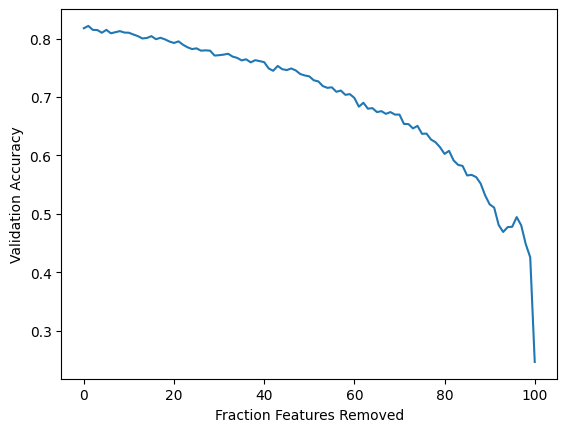

In [7]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

50% dirty, Train: 1.0000, Val: 0.7525, Test: 0.7467


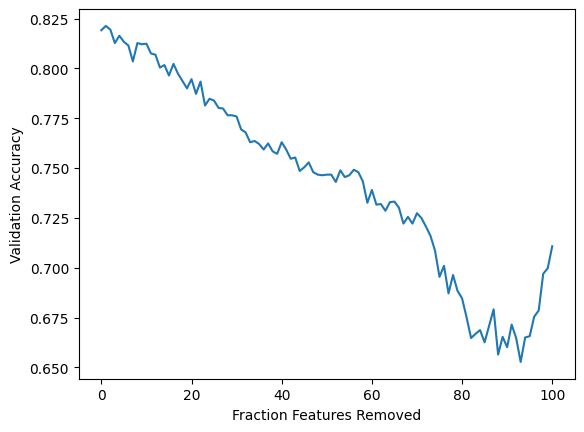

In [9]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    remove_features(data=data_copy, probability=pollution_probability, node_types=['author', 'paper'])
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

## Randomize Features

 51%|█████     | 51/100 [02:19<02:14,  2.74s/it]

50% dirty, Train: 1.0000, Val: 0.6075, Test: 0.6322


100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


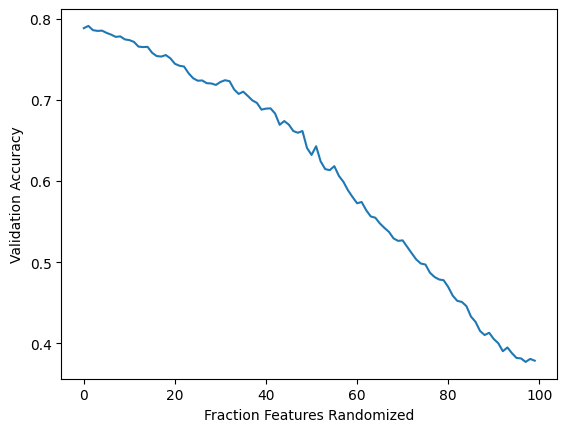

In [6]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

 51%|█████     | 51/100 [02:19<02:14,  2.74s/it]

50% dirty, Train: 1.0000, Val: 0.6075, Test: 0.6322


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


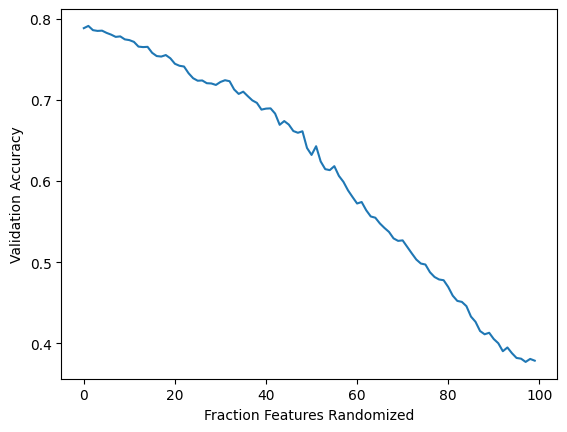

In [7]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

## Remove Edges

 51%|█████     | 51/100 [02:55<02:14,  2.75s/it]

50% dirty, Train: 0.9950, Val: 0.7650, Test: 0.7740


100%|██████████| 100/100 [04:29<00:00,  2.69s/it]


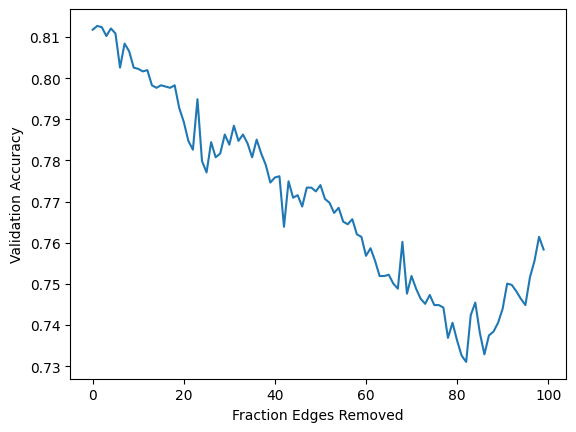

In [8]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = remove_edges(data_copy, pollution_probability)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Edges Removed')
plt.show()

 51%|█████     | 51/100 [01:52<01:31,  1.87s/it]

50% dirty, Train: 0.9850, Val: 0.5525, Test: 0.5913


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


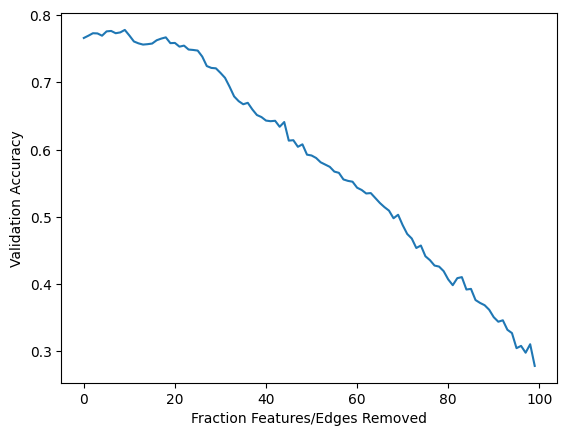

In [9]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = graph_polluters.remove_edges(data_copy, pollution_probability)
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features/Edges Removed')
plt.show()

In [2]:
a = torch.as_tensor([1,1,3,3,1,2])

In [3]:
import torch_geometric.utils


torch_geometric.utils.degree(a)

tensor([0., 3., 1., 2.])

In [4]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [8]:
torch_geometric.utils.degree(data[('author', 'to', 'paper')].edge_index[0])

tensor([ 2., 10.,  3.,  ...,  1.,  1.,  1.])

In [10]:
data.node_types

['author', 'paper', 'term', 'conference']

In [26]:
import torch.nn.functional as F

def get_degrees_one_hot(data):
    degrees = {}
    for node_type in data.node_types:
        degrees[node_type] = torch.zeros(data[node_type].x.shape[0])

    for edge_type, edge_storage in data.edge_items():
        out_node_type = edge_type[0]
        edge_index = edge_storage['edge_index']
        a = degrees[out_node_type]
        degrees[out_node_type] += torch_geometric.utils.degree(edge_index[0], num_nodes=degrees[out_node_type].shape[0])

    encodings = {}
    for node_type in data.node_types:
        encoded = F.one_hot(degrees[node_type].to(torch.int64))
        non_empty_mask = encoded.abs().sum(dim=0).bool()
        encodings[node_type] = encoded[:,non_empty_mask]

    return encodings

In [27]:
degrees

{'author': tensor([ 2., 10.,  3.,  ...,  1.,  1.,  1.]),
 'paper': tensor([ 7.,  9.,  9.,  ...,  8.,  7., 14.]),
 'term': tensor([204.,  65.,  23.,  ...,   1.,   1.,   1.]),
 'conference': tensor([1592.,  721.,  225.,  204.,  192.,  300., 1423.,  525.,  632., 1814.,
          795.,  367.,  287.,  456.,  244., 1374., 1353., 1471.,  342.,   11.])}

In [3]:
import torch


In [5]:
buckets = torch.tensor([1,2,3,5,10] + list(range(20,50+1,10)))

In [6]:
thing = torch.tensor([0,5,1,50,60,49,31])

In [ ]:
torch.bucketize(thing,buckets)